In [ ]:
# poker_baseline.ipynb

# Cell 1: Setup
import requests
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Config
CONFIG = {
    'n_files': None,  # None = 전체 사용
    'batch_size': 32,  # 데이터 많으니 배치 사이즈도 키움
    'learning_rate': 0.0001,
    'n_epochs': 20,  # epoch도 좀 늘림
    'hidden_dims': [1024, 512, 256],
    'test_size': 0.2,
    'random_seed': 0,
}

# Set random seeds
np.random.seed(CONFIG['random_seed'])
torch.manual_seed(CONFIG['random_seed'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("✓ Setup complete")
print(f"Config: {CONFIG}")

Using device: cuda
✓ Setup complete
Config: {'n_files': None, 'batch_size': 64, 'learning_rate': 0.0005, 'n_epochs': 10, 'hidden_dims': [1024, 512, 256], 'test_size': 0.2, 'random_seed': 42}


In [185]:
# Cell 2: Download functions (캐싱 추가)
import pickle
import os

CACHE_FILE = 'pluribus_data_cache.pkl'

def download_pluribus_files(n_files=None, use_cache=True):
    """Download Pluribus poker hand histories from all folders (with caching)"""
    
    # 캐시 확인
    if use_cache and os.path.exists(CACHE_FILE):
        print(f"Loading from cache: {CACHE_FILE}")
        with open(CACHE_FILE, 'rb') as f:
            cached_data = pickle.load(f)
        print(f"✓ Loaded {len(cached_data)} files from cache")
        
        if n_files is not None:
            return cached_data[:n_files]
        return cached_data
    
    # 캐시 없으면 다운로드
    print("No cache found. Downloading...")
    base_url = "https://api.github.com/repos/uoftcprg/phh-dataset/contents/data/pluribus"
    response = requests.get(base_url)
    
    phh_texts = []
    
    if response.status_code == 200:
        folders = response.json()
        
        for folder in folders:
            if folder['type'] != 'dir':
                continue
            
            folder_name = folder['name']
            folder_url = f"{base_url}/{folder_name}"
            folder_response = requests.get(folder_url)
            
            if folder_response.status_code == 200:
                files = folder_response.json()
                
                if len(files) == 0:
                    continue
                
                print(f"  Downloading from {folder_name}/ ({len(files)} files)...")
                
                for file_item in files:
                    file_url = f"https://raw.githubusercontent.com/uoftcprg/phh-dataset/master/data/pluribus/{folder_name}/{file_item['name']}"
                    file_response = requests.get(file_url)
                    
                    if file_response.status_code == 200:
                        phh_texts.append(file_response.text)
                        
                        if len(phh_texts) % 500 == 0:
                            print(f"    → Total downloaded: {len(phh_texts)} files")
                        
                        if n_files is not None and len(phh_texts) >= n_files:
                            print(f"  Reached limit of {n_files} files")
                            break
                
                if n_files is not None and len(phh_texts) >= n_files:
                    break
    
    # 캐시 저장
    if len(phh_texts) > 0:
        print(f"\nSaving to cache: {CACHE_FILE}")
        with open(CACHE_FILE, 'wb') as f:
            pickle.dump(phh_texts, f)
        print(f"✓ Cached {len(phh_texts)} files")
    
    return phh_texts

print("✓ Download functions ready (with caching)")

✓ Download functions ready (with caching)


In [186]:
# Cell 3: Parsing functions
def parse_phh_hand(phh_text):
    """Parse PHH text into structured data"""
    hand = {}
    
    variant_match = re.search(r"variant = '(\w+)'", phh_text)
    if variant_match:
        hand['variant'] = variant_match.group(1)
    
    antes_match = re.search(r"antes = \[([\d, ]+)\]", phh_text)
    if antes_match:
        hand['antes'] = [int(x.strip()) for x in antes_match.group(1).split(',')]
    
    blinds_match = re.search(r"blinds_or_straddles = \[([\d, ]+)\]", phh_text)
    if blinds_match:
        hand['blinds'] = [int(x.strip()) for x in blinds_match.group(1).split(',')]
    
    stacks_match = re.search(r"starting_stacks = \[([\d, ]+)\]", phh_text)
    if stacks_match:
        hand['starting_stacks'] = [int(x.strip()) for x in stacks_match.group(1).split(',')]
    
    actions_match = re.search(r"actions = \[(.*?)\]", phh_text, re.DOTALL)
    if actions_match:
        actions_str = actions_match.group(1)
        action_list = re.findall(r"'([^']+)'", actions_str)
        hand['actions'] = action_list
    
    players_match = re.search(r"players = \[(.*?)\]", phh_text)
    if players_match:
        players_str = players_match.group(1)
        hand['players'] = [p.strip().strip("'") for p in players_str.split(',')]
    
    return hand

def parse_cards(card_str):
    """Parse card string into list of cards (e.g., 'TcQc' -> ['Tc', 'Qc'])"""
    cards = []
    i = 0
    while i < len(card_str):
        if i + 1 < len(card_str):
            cards.append(card_str[i:i+2])
            i += 2
        else:
            i += 1
    return cards

print("✓ Parsing functions ready")

✓ Parsing functions ready


In [187]:
# Cell 4: Feature extraction
def card_to_index(card):
    """Convert card to 0-51 index"""
    if len(card) != 2:
        return -1
    
    rank_map = {'2': 0, '3': 1, '4': 2, '5': 3, '6': 4, '7': 5, '8': 6, 
                '9': 7, 'T': 8, 'J': 9, 'Q': 10, 'K': 11, 'A': 12}
    suit_map = {'c': 0, 'd': 1, 'h': 2, 's': 3}
    
    rank = card[0]
    suit = card[1]
    
    if rank in rank_map and suit in suit_map:
        return rank_map[rank] * 4 + suit_map[suit]
    return -1

def state_to_features(state):
    """
    Convert game state to feature vector (377-dim)
    - Hole cards: 104 dim (52 * 2)
    - Board cards: 260 dim (52 * 5)
    - Position: 6 dim
    - Street: 4 dim
    - Numeric: 3 dim (pot, stack, bet_to_call)
    """
    features = []
    
    # Hole cards
    hole_cards_vec = np.zeros(104)
    hole_cards = state['hole_cards']
    for i, card in enumerate(hole_cards[:2]):
        idx = card_to_index(card)
        if idx >= 0:
            hole_cards_vec[i * 52 + idx] = 1
    features.extend(hole_cards_vec)
    
    # Board cards
    board_cards_vec = np.zeros(260)
    board_cards = state['board_cards']
    for i, card in enumerate(board_cards[:5]):
        idx = card_to_index(card)
        if idx >= 0:
            board_cards_vec[i * 52 + idx] = 1
    features.extend(board_cards_vec)
    
    # Position
    position_vec = np.zeros(6)
    if 0 <= state['position'] < 6:
        position_vec[state['position']] = 1
    features.extend(position_vec)
    
    # Street
    street_map = {'preflop': 0, 'flop': 1, 'turn': 2, 'river': 3}
    street_vec = np.zeros(4)
    if state['street'] in street_map:
        street_vec[street_map[state['street']]] = 1
    features.extend(street_vec)
    
    # Numeric features (normalized by 10000 chips)
    pot_norm = state['pot'] / 10000.0
    stack_norm = state['stack'] / 10000.0
    bet_to_call_norm = state['bet_to_call'] / 10000.0
    features.extend([pot_norm, stack_norm, bet_to_call_norm])
    
    return np.array(features)

print("✓ Feature extraction ready")

✓ Feature extraction ready


In [188]:
# Cell 5: Action labeling
def categorize_action(action_type, action_amount, bet_to_call, pot, stack):
    """
    Categorize action into discrete classes:
    0: fold
    1: check_call
    2: raise_small (< 0.5x pot)
    3: raise_medium (0.5-1.5x pot)
    4: raise_large (> 1.5x pot)
    5: all_in
    """
    if action_type == 'f':
        return 0
    elif action_type == 'cc':
        return 1
    elif action_type == 'cbr':
        raise_amount = action_amount - bet_to_call
        
        if raise_amount >= stack * 0.95:
            return 5
        
        if raise_amount < pot * 0.5:
            return 2
        elif raise_amount < pot * 1.5:
            return 3
        else:
            return 4
    else:
        return -1

ACTION_NAMES = ['fold', 'check_call', 'raise_small', 'raise_medium', 'raise_large', 'all_in']

print("✓ Action labeling ready")

✓ Action labeling ready


In [189]:
# Cell 6: Decision point extraction
def extract_decision_points(hand, target_player='p1'):
    """Extract all decision points for a target player"""
    actions = hand.get('actions', [])
    n_players = len(hand.get('players', []))
    starting_stacks = hand.get('starting_stacks', [])
    blinds = hand.get('blinds', [])
    
    current_stacks = starting_stacks.copy()
    current_pot = sum(blinds)
    hole_cards = {}
    board_cards = []
    current_bets = blinds.copy()
    street = 'preflop'
    
    decision_points = []
    
    for action in actions:
        parts = action.split()
        
        if parts[0] == 'd':
            if parts[1] == 'dh':
                player = parts[2]
                if len(parts) > 3:
                    cards_str = parts[3]
                    hole_cards[player] = parse_cards(cards_str)
            elif parts[1] == 'db':
                if len(parts) > 2:
                    cards_str = parts[2]
                    new_cards = parse_cards(cards_str)
                    
                    prev_board_len = len(board_cards)
                    board_cards.extend(new_cards)
                    
                    if prev_board_len < 3 and len(board_cards) >= 3:
                        street = 'flop'
                        current_bets = [0] * n_players
                    elif prev_board_len < 4 and len(board_cards) >= 4:
                        street = 'turn'
                        current_bets = [0] * n_players
                    elif prev_board_len < 5 and len(board_cards) >= 5:
                        street = 'river'
                        current_bets = [0] * n_players
        
        elif parts[0].startswith('p'):
            player = parts[0]
            player_idx = int(player[1:]) - 1
            
            if player == target_player:
                state = {
                    'street': street,
                    'hole_cards': hole_cards.get(player, []),
                    'board_cards': board_cards.copy(),
                    'pot': current_pot,
                    'stack': current_stacks[player_idx],
                    'current_bet': current_bets[player_idx],
                    'bet_to_call': max(current_bets) - current_bets[player_idx],
                    'position': player_idx,
                    'n_players': n_players,
                }
                
                action_type = parts[1] if len(parts) > 1 else 'unknown'
                action_amount = int(parts[2]) if len(parts) > 2 and parts[2].isdigit() else 0
                
                decision_points.append({
                    'state': state,
                    'action_type': action_type,
                    'action_amount': action_amount,
                })
            
            if len(parts) > 1:
                action_type = parts[1]
                
                if action_type == 'f':
                    pass
                elif action_type == 'cc':
                    amount_to_call = max(current_bets) - current_bets[player_idx]
                    current_stacks[player_idx] -= amount_to_call
                    current_bets[player_idx] += amount_to_call
                    current_pot += amount_to_call
                elif action_type == 'cbr':
                    total_bet = int(parts[2])
                    amount_to_add = total_bet - current_bets[player_idx]
                    current_stacks[player_idx] -= amount_to_add
                    current_bets[player_idx] = total_bet
                    current_pot += amount_to_add

    return decision_points

print("✓ Decision point extraction ready")

✓ Decision point extraction ready


In [190]:
import requests
from datetime import datetime

response = requests.get("https://api.github.com/repos/uoftcprg/phh-dataset")
reset_time = int(response.headers.get('X-RateLimit-Reset', 0))
remaining = response.headers.get('X-RateLimit-Remaining', 'Unknown')

print(f"Remaining requests: {remaining}")
if reset_time:
    reset_dt = datetime.fromtimestamp(reset_time)
    print(f"Resets at: {reset_dt}")
    print(f"Time until reset: {reset_dt - datetime.now()}")

Remaining requests: 59
Resets at: 2025-11-04 09:53:12
Time until reset: 0:59:59.417323


In [191]:
# Cell 7: Download and process data
print("Downloading data...")
phh_texts = download_pluribus_files(n_files=CONFIG['n_files'])
print(f"✓ Downloaded {len(phh_texts)} files")

print("\nExtracting decision points...")
all_X = []
all_y = []

for phh_text in phh_texts:
    hand = parse_phh_hand(phh_text)
    
    # Extract from all players
    for player_idx in range(1, len(hand.get('players', [])) + 1):
        target_player = f'p{player_idx}'
        decision_points = extract_decision_points(hand, target_player=target_player)
        
        for dp in decision_points:
            features = state_to_features(dp['state'])
            label = categorize_action(
                dp['action_type'],
                dp['action_amount'],
                dp['state']['bet_to_call'],
                dp['state']['pot'],
                dp['state']['stack']
            )
            
            if label >= 0:
                all_X.append(features)
                all_y.append(label)

X = np.array(all_X)
y = np.array(all_y)

print(f"✓ Extracted {len(X)} decision points")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")

# Label distribution
unique, counts = np.unique(y, return_counts=True)
print("\nLabel distribution:")
for label, count in zip(unique, counts):
    print(f"  {ACTION_NAMES[label]}: {count} ({count/len(y)*100:.1f}%)")

# *** 수정: 'Effective Number of Samples' (ENS) 기반 가중치 계산 ***
print("\nCalculating class weights (Effective Number of Samples)...")

n_classes = len(ACTION_NAMES)
beta = 0.9999  # 하이퍼파라미터 (0.9 ~ 0.9999)
# beta가 1에 가까울수록 (1/counts)와 유사해지고, 0에 가까울수록 (모든 가중치=1)과 유사해짐

effective_num = 1.0 - np.power(beta, counts)
weights = (1.0 - beta) / effective_num

# 가중치를 전체 합으로 정규화 (Loss 스케일 안정화)
weights = weights / np.sum(weights) * n_classes

class_weights = torch.FloatTensor(weights).to(device)

print(f"Calculated ENS class weights (beta={beta}):\n{class_weights}")

Loading from cache: pluribus_data_cache.pkl
✓ Loaded 6619 files from cache
✓ Downloaded 6619 files

Extracting decision points...
✓ Extracted 60422 decision points
  X shape: (60422, 377)
  y shape: (60422,)

Label distribution:
  fold: 31958 (52.9%)
  check_call: 16207 (26.8%)
  raise_small: 1459 (2.4%)
  raise_medium: 8826 (14.6%)
  raise_large: 1834 (3.0%)
  all_in: 138 (0.2%)

Calculating class weights (Effective Number of Samples)...
Calculated ENS class weights (beta=0.9999):
tensor([0.0693, 0.0828, 0.4895, 0.1133, 0.3966, 4.8485], device='cuda:0')


In [192]:
# Cell 8: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=CONFIG['test_size'], random_state=CONFIG['random_seed']
)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'])

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Train size: 48337
Test size: 12085


In [193]:
# Cell 9: Model definition
class PokerMLP(nn.Module):
    def __init__(self, input_dim=377, hidden_dims=[256, 128, 64], output_dim=6):
        super(PokerMLP, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

model = PokerMLP(
    input_dim=377,
    hidden_dims=CONFIG['hidden_dims'],
    output_dim=6
).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])

total_params = sum(p.numel() for p in model.parameters())
print(f"Model created with {total_params:,} parameters")

Model created with 1,044,742 parameters


In [194]:
# Cell 10: Training
print("Training...")
train_losses = []
train_accs = []

for epoch in range(CONFIG['n_epochs']):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for X_batch, y_batch in train_loader:
        # *** 추가: 데이터를 device로 이동 ***
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += y_batch.size(0)
        train_correct += (predicted == y_batch).sum().item()
    
    avg_loss = train_loss / len(train_loader)
    train_acc = 100 * train_correct / train_total
    
    train_losses.append(avg_loss)
    train_accs.append(train_acc)
    
    print(f"Epoch {epoch+1}/{CONFIG['n_epochs']}: Loss={avg_loss:.4f}, Acc={train_acc:.2f}%")

print("\n✓ Training complete")

Training...
Epoch 1/10: Loss=1.1703, Acc=63.62%
Epoch 2/10: Loss=0.9608, Acc=65.84%
Epoch 3/10: Loss=0.8286, Acc=69.07%
Epoch 4/10: Loss=0.7150, Acc=72.36%
Epoch 5/10: Loss=0.6189, Acc=75.19%
Epoch 6/10: Loss=0.5462, Acc=77.71%
Epoch 7/10: Loss=0.4847, Acc=80.03%
Epoch 8/10: Loss=0.4299, Acc=81.95%
Epoch 9/10: Loss=0.3910, Acc=83.59%
Epoch 10/10: Loss=0.3529, Acc=85.09%

✓ Training complete


In [195]:
# Cell 11: Evaluation (수정)
model.eval()
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # *** 추가: 데이터를 device로 이동 ***
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        test_total += y_batch.size(0)
        test_correct += (predicted == y_batch).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

test_acc = 100 * test_correct / test_total
print(f"Test Accuracy: {test_acc:.2f}%\n")

# Classification report (labels 파라미터 추가)
print("Classification Report:")
print(classification_report(
    all_labels, 
    all_preds, 
    labels=list(range(6)),  # 0-5 모든 클래스 명시
    target_names=ACTION_NAMES, 
    zero_division=0
))

Test Accuracy: 75.03%

Classification Report:
              precision    recall  f1-score   support

        fold       0.93      0.85      0.89      6367
  check_call       0.64      0.68      0.66      3274
 raise_small       0.21      0.20      0.21       309
raise_medium       0.65      0.64      0.64      1727
 raise_large       0.32      0.66      0.44       376
      all_in       0.44      0.34      0.39        32

    accuracy                           0.75     12085
   macro avg       0.53      0.56      0.54     12085
weighted avg       0.77      0.75      0.76     12085



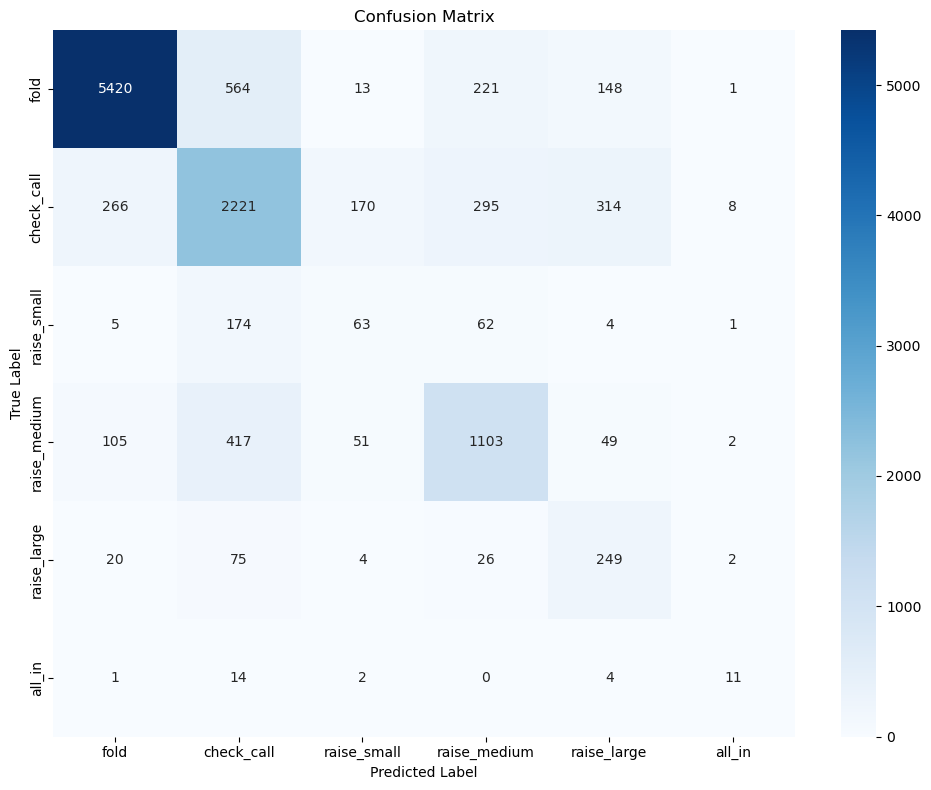

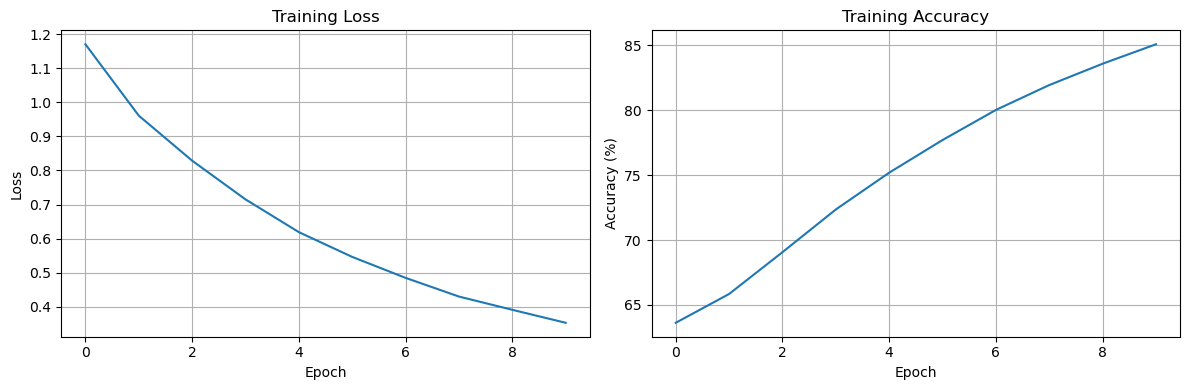

In [196]:
# Cell 12: Confusion matrix visualization
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=ACTION_NAMES, yticklabels=ACTION_NAMES)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses)
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)

ax2.plot(train_accs)
ax2.set_title('Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [17]:
!pip install treys

In [197]:
# Cell 13: Poker Environment
from treys import Card, Evaluator, Deck

class PokerGame:
    """6-player No-Limit Texas Hold'em Environment (Pluribus settings)"""
    
    def __init__(self, n_players=6, starting_stack=10000, small_blind=50, big_blind=100):
        self.n_players = n_players
        self.starting_stack = starting_stack
        self.small_blind = small_blind
        self.big_blind = big_blind
        self.evaluator = Evaluator()
        self.reset()
    
    def reset(self):
        """Start a new hand"""
        self.deck = Deck()
        self.stacks = [self.starting_stack] * self.n_players
        self.pot = 0
        self.current_bets = [0] * self.n_players
        self.hole_cards = [[] for _ in range(self.n_players)]
        self.board_cards = []
        self.folded = [False] * self.n_players
        self.street = 'preflop'
        self.button = 0
        
        # Post blinds
        sb_pos = (self.button + 1) % self.n_players
        bb_pos = (self.button + 2) % self.n_players
        self.current_bets[sb_pos] = self.small_blind
        self.current_bets[bb_pos] = self.big_blind
        self.stacks[sb_pos] -= self.small_blind
        self.stacks[bb_pos] -= self.big_blind
        self.pot = self.small_blind + self.big_blind
        
        # Deal hole cards
        for i in range(self.n_players):
            self.hole_cards[i] = [self.deck.draw(1)[0], self.deck.draw(1)[0]]
        
        return self.get_state(0)
    
    def get_state(self, player_idx):
        """Get state from player's perspective"""
        return {
            'street': self.street,
            'hole_cards': self.hole_cards[player_idx],
            'board_cards': self.board_cards.copy(),
            'pot': self.pot,
            'stack': self.stacks[player_idx],
            'current_bet': self.current_bets[player_idx],
            'bet_to_call': max(self.current_bets) - self.current_bets[player_idx],
            'position': player_idx,
            'n_players': self.n_players,
        }
    
    def step(self, player_idx, action_type, amount=0):
        """Execute an action"""
        if self.folded[player_idx]:
            return
        
        if action_type == 'fold':
            self.folded[player_idx] = True
        elif action_type == 'call':
            call_amount = max(self.current_bets) - self.current_bets[player_idx]
            call_amount = min(call_amount, self.stacks[player_idx])
            self.stacks[player_idx] -= call_amount
            self.current_bets[player_idx] += call_amount
            self.pot += call_amount
        elif action_type == 'raise':
            additional = amount - self.current_bets[player_idx]
            additional = min(additional, self.stacks[player_idx])
            self.stacks[player_idx] -= additional
            self.current_bets[player_idx] += additional
            self.pot += additional
    
    def advance_street(self):
        """Move to next betting round"""
        self.current_bets = [0] * self.n_players
        
        if self.street == 'preflop':
            self.board_cards = self.deck.draw(3)
            self.street = 'flop'
        elif self.street == 'flop':
            self.board_cards.extend(self.deck.draw(1))
            self.street = 'turn'
        elif self.street == 'turn':
            self.board_cards.extend(self.deck.draw(1))
            self.street = 'river'
        elif self.street == 'river':
            self.street = 'showdown'
    
    def is_betting_round_over(self):
        """Check if current betting round is complete"""
        active_players = [i for i in range(self.n_players) if not self.folded[i]]
        if len(active_players) <= 1:
            return True
        
        max_bet = max(self.current_bets)
        for i in active_players:
            if self.current_bets[i] < max_bet and self.stacks[i] > 0:
                return False
        return True
    
    def get_winners(self):
        """Determine winners and distribute pot"""
        active_players = [i for i in range(self.n_players) if not self.folded[i]]
        
        if len(active_players) == 1:
            return {active_players[0]: self.pot}
        
        # Showdown
        best_rank = float('inf')
        winners = []
        
        for player_idx in active_players:
            hand = self.hole_cards[player_idx]
            rank = self.evaluator.evaluate(self.board_cards, hand)
            
            if rank < best_rank:
                best_rank = rank
                winners = [player_idx]
            elif rank == best_rank:
                winners.append(player_idx)
        
        pot_per_winner = self.pot / len(winners)
        return {winner: pot_per_winner for winner in winners}

print("✓ Poker environment ready")

✓ Poker environment ready


In [ ]:
# Cell 14 (수정됨): Rule-based Bots (훈련 데이터 기준으로 베팅 단위 통일)
from treys import Card, Evaluator, Deck
import numpy as np

class BaseBot:
    """Base class for poker bots"""
    def __init__(self, name):
        self.name = name
    
    def get_action(self, state, game):
        """Return (action_type, amount)"""
        raise NotImplementedError

class RandomBot(BaseBot):
    """(수정됨) 훈련 데이터와 동일한 pot 기준 베팅을 하는 랜덤 봇"""
    def get_action(self, state, game):
        bet_to_call = state['bet_to_call']
        
        # 가능한 액션 리스트
        possible_actions = ['call']
        
        # 0벳일 경우 (체크 가능)
        if bet_to_call == 0:
            possible_actions.extend(['raise_small', 'raise_medium', 'raise_large', 'all_in'])
        
        # 벳이 있을 경우 (콜 또는 레이즈 가능)
        else:
            possible_actions.extend(['fold', 'raise_small', 'raise_medium', 'raise_large', 'all_in'])
                    
        # 액션 선택
        action = np.random.choice(possible_actions)
        
        if action == 'fold':
            # 벳이 0일 때 폴드를 선택하면 체크로 변경
            return ('call', 0) if bet_to_call == 0 else ('fold', 0)
        
        if action == 'call':
            return ('call', 0)
        
        # --- [수정된 pot 기준 레이즈 로직] ---
        # 훈련 데이터(Cell 5)와 동일한 방식:
        # raise_amount = action_amount - bet_to_call
        # raise_amount를 pot(콜 금액 제외)과 비교
        
        pot = state['pot']
        stack = state['stack']
        current_bet = state['current_bet']
        
        # 최소 레이즈 금액 계산
        max_current_bet = max(game.current_bets)
        if max_current_bet == 0:
            # 아무도 베팅하지 않은 경우 (프리플랍 BB 제외)
            min_raise_size = game.big_blind
        else:
            # 이전 레이즈 크기 계산
            sorted_bets = sorted(game.current_bets, reverse=True)
            if len(sorted_bets) >= 2:
                previous_raise_size = sorted_bets[0] - sorted_bets[1]
            else:
                previous_raise_size = game.big_blind
            min_raise_size = max(previous_raise_size, game.big_blind)
        
        min_raise_total_bet = max_current_bet + min_raise_size

        # raise_amount: 콜 금액을 제외한 순수 레이즈 금액
        raise_amount = 0
        
        if action == 'raise_small':  # (< 0.5x pot)
            raise_amount = pot * np.random.uniform(0.2, 0.49)
            
        elif action == 'raise_medium':  # (0.5-1.5x pot)
            raise_amount = pot * np.random.uniform(0.5, 1.49)
            
        elif action == 'raise_large':  # (> 1.5x pot)
            raise_amount = pot * np.random.uniform(1.5, 2.5)

        elif action == 'all_in':
            return ('raise', stack + current_bet)  # 올인
            
        # 최종 베팅액: 현재 베팅 + 콜할 금액 + 레이즈 금액
        total_bet = int(current_bet + bet_to_call + raise_amount)
        
        # 최소 레이즈 제약 적용
        if total_bet < min_raise_total_bet:
            total_bet = min_raise_total_bet
        
        # 스택보다 많이 베팅할 수 없음
        total_bet = min(total_bet, stack + current_bet)

        # 레이즈 금액이 콜 금액보다 작으면 콜로 변경
        if total_bet <= current_bet + bet_to_call:
            return ('call', 0)
            
        return ('raise', total_bet)


class TightPassiveBot(BaseBot):
    """Only plays good hands, rarely raises (훈련 데이터 기준)"""
    def get_action(self, state, game):
        hole_cards = state['hole_cards']
        rank1 = Card.get_rank_int(hole_cards[0])
        rank2 = Card.get_rank_int(hole_cards[1])
        is_pair = (rank1 == rank2)
        has_high_card = (rank1 >= 9 or rank2 >= 9)  # Jack or better
        bet_to_call = state['bet_to_call']
        
        if not is_pair and not has_high_card and bet_to_call > 0:
            return ('fold', 0)
        
        if np.random.random() < 0.9:  # 90% call
            return ('call', 0)
        else:  # 10% small raise (pot의 0.35배)
            pot = state['pot']
            stack = state['stack']
            current_bet = state['current_bet']
            
            # 최소 레이즈 계산
            max_current_bet = max(game.current_bets)
            sorted_bets = sorted(game.current_bets, reverse=True)
            if len(sorted_bets) >= 2 and sorted_bets[0] > 0:
                previous_raise_size = sorted_bets[0] - sorted_bets[1]
            else:
                previous_raise_size = game.big_blind
            min_raise_size = max(previous_raise_size, game.big_blind)
            min_raise_total_bet = max_current_bet + min_raise_size
            
            raise_amount = pot * 0.35  # raise_small 범위
            total_bet = int(current_bet + bet_to_call + raise_amount)
            
            if total_bet < min_raise_total_bet:
                total_bet = min_raise_total_bet
            
            total_bet = min(total_bet, stack + current_bet)
            
            if total_bet <= current_bet + bet_to_call:
                return ('call', 0)
            return ('raise', total_bet)

class LooseAggressiveBot(BaseBot):
    """Plays many hands, raises frequently (훈련 데이터 기준)"""
    def get_action(self, state, game):
        bet_to_call = state['bet_to_call']
        
        if bet_to_call > state['stack'] * 0.5:
            if np.random.random() < 0.3:
                return ('fold', 0)
        
        if np.random.random() < 0.6:  # 60% raise
            pot = state['pot']
            stack = state['stack']
            current_bet = state['current_bet']
            
            # 최소 레이즈 계산
            max_current_bet = max(game.current_bets)
            sorted_bets = sorted(game.current_bets, reverse=True)
            if len(sorted_bets) >= 2 and sorted_bets[0] > 0:
                previous_raise_size = sorted_bets[0] - sorted_bets[1]
            else:
                previous_raise_size = game.big_blind
            min_raise_size = max(previous_raise_size, game.big_blind)
            min_raise_total_bet = max_current_bet + min_raise_size
            
            # 0.5x ~ 2x pot 레이즈
            raise_amount = pot * np.random.uniform(0.5, 2.0)
            total_bet = int(current_bet + bet_to_call + raise_amount)
            
            if total_bet < min_raise_total_bet:
                total_bet = min_raise_total_bet
            
            total_bet = min(total_bet, stack + current_bet)
            
            if total_bet <= current_bet + bet_to_call:
                return ('call', 0)
            return ('raise', total_bet)
        else:
            return ('call', 0)

class CallStationBot(BaseBot):
    """Almost never folds, mostly calls (훈련 데이터 기준)"""
    def get_action(self, state, game):
        bet_to_call = state['bet_to_call']
        
        if bet_to_call >= state['stack'] * 0.8:
            if np.random.random() < 0.2:
                return ('fold', 0)
        
        if np.random.random() < 0.95:  # 95% call
            return ('call', 0)
        else:  # 5% small raise (pot의 0.3배)
            pot = state['pot']
            stack = state['stack']
            current_bet = state['current_bet']
            
            # 최소 레이즈 계산
            max_current_bet = max(game.current_bets)
            sorted_bets = sorted(game.current_bets, reverse=True)
            if len(sorted_bets) >= 2 and sorted_bets[0] > 0:
                previous_raise_size = sorted_bets[0] - sorted_bets[1]
            else:
                previous_raise_size = game.big_blind
            min_raise_size = max(previous_raise_size, game.big_blind)
            min_raise_total_bet = max_current_bet + min_raise_size
            
            raise_amount = pot * 0.3  # raise_small 범위
            total_bet = int(current_bet + bet_to_call + raise_amount)
            
            if total_bet < min_raise_total_bet:
                total_bet = min_raise_total_bet
            
            total_bet = min(total_bet, stack + current_bet)
            
            if total_bet <= current_bet + bet_to_call:
                return ('call', 0)
            return ('raise', total_bet)
        
class MonteCarloBot(BaseBot):
    """
    Decides action based on Monte Carlo Equity simulation.
    Uses pot-based betting sizes consistent with training data.
    """
    def __init__(self, name, n_simulations=500):
        super().__init__(name)
        self.n_simulations = n_simulations
        self.evaluator = Evaluator()

    def calculate_equity(self, hole_cards, community_cards):
        visible_cards = hole_cards + community_cards
        
        wins = 0
        ties = 0
        
        deck = Deck()
        board_len = len(community_cards)
        cards_to_deal = 5 - board_len
        
        for _ in range(self.n_simulations):
            deck.shuffle()
            
            # Reset deck excluding visible cards
            deck.cards = [c for c in Deck.GetFullDeck() if c not in visible_cards]
            np.random.shuffle(deck.cards)
            
            opp_hole = deck.draw(2)
            sim_board = community_cards + deck.draw(cards_to_deal)
            
            my_score = self.evaluator.evaluate(hole_cards, sim_board)
            opp_score = self.evaluator.evaluate(opp_hole, sim_board)
            
            if my_score < opp_score:
                wins += 1
            elif my_score == opp_score:
                ties += 1
                
        return (wins + (ties * 0.5)) / self.n_simulations

    def get_action(self, state, game):
        hole_cards = state['hole_cards']
        community_cards = state['community_cards']
        bet_to_call = state['bet_to_call']
        pot = state['pot']
        stack = state['stack']
        current_bet = state['current_bet']
        
        # Calculate Equity
        equity = self.calculate_equity(hole_cards, community_cards)
        
        # Calculate Pot Odds
        current_pot_total = pot + bet_to_call 
        if current_pot_total > 0:
            pot_odds = bet_to_call / (current_pot_total + bet_to_call)
        else:
            pot_odds = 0
            
        action_type = 'fold'
        
        # Check possible (bet_to_call == 0)
        if bet_to_call == 0:
            if equity > 0.7:
                action_type = 'raise_large'
            elif equity > 0.6:
                action_type = 'raise_medium'
            elif equity > 0.5:
                action_type = 'raise_small'
            else:
                return ('call', 0)
        
        # Facing a bet
        else:
            if equity < pot_odds:
                return ('fold', 0)
            
            if equity > 0.8:
                action_type = np.random.choice(['raise_large', 'all_in'], p=[0.7, 0.3])
            elif equity > 0.7:
                action_type = 'raise_medium'
            elif equity > 0.6:
                action_type = 'raise_small'
            else:
                return ('call', 0)

        # Calculate Raise Amount
        max_current_bet = max(game.current_bets)
        if max_current_bet == 0:
            min_raise_size = game.big_blind
        else:
            sorted_bets = sorted(game.current_bets, reverse=True)
            if len(sorted_bets) >= 2:
                previous_raise_size = sorted_bets[0] - sorted_bets[1]
            else:
                previous_raise_size = game.big_blind
            min_raise_size = max(previous_raise_size, game.big_blind)
        
        min_raise_total_bet = max_current_bet + min_raise_size

        raise_amount = 0
        
        if action_type == 'raise_small':
            raise_amount = pot * np.random.uniform(0.2, 0.49)
        elif action_type == 'raise_medium':
            raise_amount = pot * np.random.uniform(0.5, 1.49)
        elif action_type == 'raise_large':
            raise_amount = pot * np.random.uniform(1.5, 2.5)
        elif action_type == 'all_in':
            return ('raise', stack + current_bet)

        total_bet = int(current_bet + bet_to_call + raise_amount)
        
        if total_bet < min_raise_total_bet:
            total_bet = min_raise_total_bet
        
        total_bet = min(total_bet, stack + current_bet)

        if total_bet <= current_bet + bet_to_call:
            return ('call', 0)
            
        return ('raise', total_bet)
    
class BullyBot(BaseBot):
    """
    Aggressive Stealer.
    - If opponent checks (bet_to_call == 0), ALWAYS bets/raises to steal.
    - If opponent bets (bet_to_call > 0), plays honest/tight (folds weak hands).
    """
    def get_action(self, state, game):
        bet_to_call = state['bet_to_call']
        pot = state['pot']
        stack = state['stack']
        current_bet = state['current_bet']
        hole_cards = state['hole_cards']
        
        # 1. Opportunity to Steal
        if bet_to_call == 0:
            action_type = 'raise'
            raise_factor = np.random.uniform(0.3, 0.6) 
            
        else:
            rank1 = Card.get_rank_int(hole_cards[0])
            rank2 = Card.get_rank_int(hole_cards[1])
            if rank1 < 10 and rank2 < 10 and rank1 != rank2:
                return ('fold', 0)
            
            return ('call', 0)

        # --- Raise Calculation ---
        max_current_bet = max(game.current_bets)
        sorted_bets = sorted(game.current_bets, reverse=True)
        if len(sorted_bets) >= 2 and sorted_bets[0] > 0:
            previous_raise_size = sorted_bets[0] - sorted_bets[1]
        else:
            previous_raise_size = game.big_blind
        min_raise_size = max(previous_raise_size, game.big_blind)
        min_raise_total_bet = max_current_bet + min_raise_size
        
        raise_amount = pot * raise_factor
        total_bet = int(current_bet + bet_to_call + raise_amount)
        
        if total_bet < min_raise_total_bet:
            total_bet = min_raise_total_bet
        total_bet = min(total_bet, stack + current_bet)
        
        if total_bet <= current_bet + bet_to_call:
            return ('call', 0)
            
        return ('raise', total_bet)
    
class NitBot(BaseBot):
    """
    (Super Tight Aggressive)
    - 상위 10% 핸드만 플레이.
    - 림프(Call) 없음. 참여 시 무조건 Raise.
    - 이 봇이 베팅하면 정말 강한 패라는 뜻.
    """
    def get_action(self, state, game):
        hole_cards = state['hole_cards']
        bet_to_call = state['bet_to_call']
        
        rank1 = Card.get_rank_int(hole_cards[0])
        rank2 = Card.get_rank_int(hole_cards[1])
        is_pair = (rank1 == rank2)
        is_high_cards = (rank1 >= 10 and rank2 >= 10)
        
        if not (is_pair or is_high_cards):
            if bet_to_call > 0:
                return ('fold', 0)
            return ('call', 0)
            
        pot = state['pot']
        stack = state['stack']
        current_bet = state['current_bet']
        
        max_current_bet = max(game.current_bets)
        sorted_bets = sorted(game.current_bets, reverse=True)
        if len(sorted_bets) >= 2 and sorted_bets[0] > 0:
            previous_raise_size = sorted_bets[0] - sorted_bets[1]
        else:
            previous_raise_size = game.big_blind
        min_raise_size = max(previous_raise_size, game.big_blind)
        min_raise_total_bet = max_current_bet + min_raise_size
        
        raise_amount = pot * np.random.uniform(0.7, 1.2)
        total_bet = int(current_bet + bet_to_call + raise_amount)
        
        if total_bet < min_raise_total_bet:
            total_bet = min_raise_total_bet
        total_bet = min(total_bet, stack + current_bet)
        
        if total_bet <= current_bet + bet_to_call:
            return ('call', 0)
            
        return ('raise', total_bet)

print("✓ Rule-based bots ready (Training data compatible - pot-based betting)")
print("  - RandomBot: Uses pot-based raises (matching training data)")
print("  - TightPassiveBot: Good hands, rarely raises (pot-based)")
print("  - LooseAggressiveBot: Many hands, frequent raises (pot-based)")
print("  - CallStationBot: Almost never folds (pot-based)")

✓ Rule-based bots ready (Training data compatible - pot-based betting)
  - RandomBot: Uses pot-based raises (matching training data)
  - TightPassiveBot: Good hands, rarely raises (pot-based)
  - LooseAggressiveBot: Many hands, frequent raises (pot-based)
  - CallStationBot: Almost never folds (pot-based)


In [199]:
# Cell 15 (수정됨): Model Player Wrapper (훈련 데이터 기준으로 베팅 단위 통일)
from treys import Card, Evaluator, Deck
import numpy as np
import torch

class ModelPlayer(BaseBot):
    """(수정됨) 훈련된 MLP 모델 래퍼 - 훈련 데이터와 동일한 베팅 기준 사용"""
    def __init__(self, model, name="ModelPlayer"):
        super().__init__(name)
        self.model = model
        self.model.eval()
    
    def card_to_index(self, card):
        """Convert treys card to 0-51 index"""
        rank = Card.get_rank_int(card)
        suit_int = Card.get_suit_int(card)
        suit_map = {1: 0, 2: 1, 4: 2, 8: 3}  # s, h, d, c -> 0, 1, 2, 3
        suit = suit_map.get(suit_int, 0)
        return rank * 4 + suit
    
    def state_to_features(self, state):
        """Convert state to feature vector (same as training)"""
        features = []
        
        # Hole cards (104 dim)
        hole_cards_vec = np.zeros(104)
        for i, card in enumerate(state['hole_cards'][:2]):
            idx = self.card_to_index(card)
            if 0 <= idx < 52:
                hole_cards_vec[i * 52 + idx] = 1
        features.extend(hole_cards_vec)
        
        # Board cards (260 dim)
        board_cards_vec = np.zeros(260)
        board_cards = state['board_cards']
        for i, card in enumerate(board_cards[:5]):
            idx = self.card_to_index(card)
            if 0 <= idx < 52:
                board_cards_vec[i * 52 + idx] = 1
        features.extend(board_cards_vec)
        
        # Position (6 dim)
        position_vec = np.zeros(6)
        if 0 <= state['position'] < 6:
            position_vec[state['position']] = 1
        features.extend(position_vec)
        
        # Street (4 dim)
        street_map = {'preflop': 0, 'flop': 1, 'turn': 2, 'river': 3}
        street_vec = np.zeros(4)
        if state['street'] in street_map:
            street_vec[street_map[state['street']]] = 1
        features.extend(street_vec)

        N = 10000
        
        # Numeric features (Normalized by 10000 chips)
        pot_norm = state['pot'] / N
        stack_norm = state['stack'] / N
        bet_to_call_norm = state['bet_to_call'] / N
        features.extend([pot_norm, stack_norm, bet_to_call_norm])
        
        return np.array(features, dtype=np.float32)
    
    def get_action(self, state, game):
        """(수정됨) Get action from model prediction - 훈련 데이터 기준 베팅"""
        features = self.state_to_features(state)
        features_tensor = torch.FloatTensor(features).unsqueeze(0)
        
        # 모델 device와 일치시키기
        model_device = next(self.model.parameters()).device
        features_tensor = features_tensor.to(model_device)

        with torch.no_grad():
            outputs = self.model(features_tensor)
            action_idx = torch.argmax(outputs, dim=1).item()
        
        # 액션 인덱스 변환
        # 0: fold, 1: check_call, 2: raise_small, 3: raise_medium, 4: raise_large, 5: all_in
        
        bet_to_call = state['bet_to_call']
        
        if action_idx == 0:
            return ('call', 0) if bet_to_call == 0 else ('fold', 0)
        
        elif action_idx == 1:
            return ('call', 0)
        
        else:
            # --- [수정된 pot 기준 레이즈 로직] ---
            # 훈련 데이터(Cell 5)와 동일한 방식으로 베팅
            # raise_amount = action_amount - bet_to_call (콜 제외 순수 레이즈)
            # 이를 pot과 비교
            
            pot = state['pot']  # effective_pot 대신 pot 사용
            stack = state['stack']
            current_bet = state['current_bet']
            
            # 최소 레이즈 크기 계산
            max_current_bet = max(game.current_bets)
            if max_current_bet == 0:
                min_raise_size = game.big_blind
            else:
                sorted_bets = sorted(game.current_bets, reverse=True)
                if len(sorted_bets) >= 2 and sorted_bets[0] > 0:
                    previous_raise_size = sorted_bets[0] - sorted_bets[1]
                else:
                    previous_raise_size = game.big_blind
                min_raise_size = max(previous_raise_size, game.big_blind)
            
            min_raise_total_bet = max_current_bet + min_raise_size

            # raise_amount: 콜 금액을 제외한 순수 레이즈 금액
            raise_amount = 0

            # 모델의 의도(카테고리)를 훈련 데이터 기준 베팅액으로 매핑
            if action_idx == 2:  # raise_small (< 0.5x pot)
                raise_amount = pot * 0.35  # 0.5보다 작은 값
            elif action_idx == 3:  # raise_medium (0.5-1.5x pot)
                raise_amount = pot * 0.9   # 0.5~1.5 사이
            elif action_idx == 4:  # raise_large (> 1.5x pot)
                raise_amount = pot * 2.0   # 1.5보다 큰 값
            else:  # all_in (action_idx == 5)
                return ('raise', stack + current_bet)

            # 최종 베팅액 계산: 현재 베팅 + 콜할 금액 + 레이즈 금액
            total_bet = int(current_bet + bet_to_call + raise_amount)
            
            # 최소 레이즈 제약 적용
            if total_bet < min_raise_total_bet:
                total_bet = min_raise_total_bet
            
            # 스택 제약
            total_bet = min(total_bet, stack + current_bet)

            # 엣지 케이스 처리
            if total_bet <= current_bet + bet_to_call:
                return ('call', 0)
                
            return ('raise', total_bet)

print("✓ Model player wrapper ready (Training data compatible - pot-based betting)")

✓ Model player wrapper ready (Training data compatible - pot-based betting)


In [200]:
# Cell 16 (수정됨): Simulation Runner (홀덤 규칙 수정: 헤즈업 지원, 최소 레이즈)

def simulate_hand_with_fixed_deck_corrected(game, players, deck_cards):
    """고정된 덱으로 한 hand 시뮬레이션 (규칙 수정됨)"""
    game.deck = Deck()
    game.deck.cards = deck_cards.copy()
    
    game.stacks = [game.starting_stack] * game.n_players
    game.pot = 0
    game.current_bets = [0] * game.n_players
    game.hole_cards = [[] for _ in range(game.n_players)]
    game.board_cards = []
    game.folded = [False] * game.n_players
    game.street = 'preflop'
    game.button = 0
    
    n_players = game.n_players
    is_headsup = (n_players == 2)
    
    # Post blinds
    if is_headsup:
        # 헤즈업: BTN이 SB, 다른 플레이어가 BB
        sb_pos = game.button
        bb_pos = (game.button + 1) % n_players
    else:
        # 3명 이상: 일반 규칙
        sb_pos = (game.button + 1) % n_players
        bb_pos = (game.button + 2) % n_players
    
    game.current_bets[sb_pos] = game.small_blind
    game.current_bets[bb_pos] = game.big_blind
    game.stacks[sb_pos] -= game.small_blind
    game.stacks[bb_pos] -= game.big_blind
    game.pot = game.small_blind + game.big_blind
    
    # Deal hole cards
    for i in range(n_players):
        game.hole_cards[i] = [game.deck.draw(1)[0], game.deck.draw(1)[0]]
    
    # Betting rounds
    for street_num in range(4):
        
        # --- [수정된 턴 순서: 헤즈업 고려] ---
        if street_num == 0:  # Preflop
            if is_headsup:
                # 헤즈업: SB(=BTN)이 먼저 액션
                current_actor_idx = game.button
            else:
                # 3명 이상: UTG(BB 다음)부터
                current_actor_idx = (game.button + 3) % n_players
        else:  # Postflop (Flop, Turn, River)
            if is_headsup:
                # 헤즈업: SB(=BTN)이 먼저 액션
                current_actor_idx = game.button
            else:
                # 3명 이상: SB부터 시작
                current_actor_idx = (game.button + 1) % n_players
            
            # 폴드한 플레이어는 스킵
            loops = 0
            while game.folded[current_actor_idx] and loops < n_players:
                current_actor_idx = (current_actor_idx + 1) % n_players
                loops += 1
        
        # --- [수정된 액션 루프] ---
        players_acted_this_street = [False] * n_players
        last_raiser_idx = -1  # 마지막 레이즈한 플레이어 추적
        
        loops = 0
        max_loops = n_players * 10  # 무한 루프 방지
        
        while loops < max_loops:
            
            # 라운드 종료 조건 체크
            active_players = [i for i in range(n_players) 
                            if not game.folded[i] and game.stacks[i] > 0]
            
            # 한 명만 남으면 종료
            if len([i for i in range(n_players) if not game.folded[i]]) <= 1:
                break
            
            # 모든 베팅이 맞춰지고 모든 활성 플레이어가 액션했는지 확인
            max_bet = max(game.current_bets)
            all_bets_equal = all(
                game.current_bets[i] == max_bet or game.folded[i] or game.stacks[i] == 0
                for i in range(n_players)
            )
            
            if all_bets_equal:
                # 마지막 레이즈 이후 모든 플레이어가 액션했는지 확인
                if last_raiser_idx == -1:
                    # 레이즈가 없었다면, 모든 플레이어가 액션해야 함
                    if all(players_acted_this_street[i] or game.folded[i] or game.stacks[i] == 0 
                           for i in range(n_players)):
                        break
                else:
                    # 레이즈가 있었다면, 레이즈한 플레이어를 제외하고 모두 액션했는지 확인
                    all_responded = True
                    for i in range(n_players):
                        if i == last_raiser_idx:
                            continue
                        if not game.folded[i] and game.stacks[i] > 0:
                            if not players_acted_this_street[i]:
                                all_responded = False
                                break
                    if all_responded:
                        break
            
            # 폴드했거나 올인한 플레이어는 스킵
            if game.folded[current_actor_idx] or game.stacks[current_actor_idx] == 0:
                players_acted_this_street[current_actor_idx] = True
                current_actor_idx = (current_actor_idx + 1) % n_players
                loops += 1
                continue

            # 액션 가져오기
            state = game.get_state(current_actor_idx)
            action_type, amount = players[current_actor_idx].get_action(state, game)
            
            # 액션 유효성 검사
            if action_type == 'fold' and state['bet_to_call'] == 0:
                action_type = 'call'  # 체크
            
            # 액션 실행
            game.step(current_actor_idx, action_type, amount)
            players_acted_this_street[current_actor_idx] = True

            # 레이즈 감지
            if action_type == 'raise':
                # 새로운 레이즈가 발생하면 다른 플레이어들이 다시 액션해야 함
                new_max_bet = max(game.current_bets)
                if new_max_bet > max_bet:
                    # 액션 기록 초기화 (레이즈한 본인만 True 유지)
                    players_acted_this_street = [False] * n_players
                    players_acted_this_street[current_actor_idx] = True
                    last_raiser_idx = current_actor_idx
            
            current_actor_idx = (current_actor_idx + 1) % n_players
            loops += 1
        
        # 핸드 종료 체크
        active_players_count = sum(1 for f in game.folded if not f)
        if active_players_count <= 1:
            break
        
        # 다음 스트리트로 진행
        if street_num < 3:
            game.advance_street()
    
    winners = game.get_winners()
    return winners


def simulate_games_with_rotation(players, n_hands=1000, starting_stack=10000):
    """(수정됨) 버그가 수정된 시뮬레이터를 사용하여 rotation 평가"""
    game = PokerGame(n_players=len(players), starting_stack=starting_stack)
    n_players = len(players)
    total_profits = [0.0] * n_players
    
    for hand_num in range(n_hands):
        deck = Deck()
        original_deck = deck.cards.copy()
        
        for rotation in range(n_players):
            rotated_players = players[rotation:] + players[:rotation]
            
            # 수정된 함수 호출
            winners = simulate_hand_with_fixed_deck_corrected(game, rotated_players, original_deck)
            
            for i in range(n_players):
                original_idx = (i - rotation) % n_players
                initial = starting_stack
                final = game.stacks[i]
                winnings = winners.get(i, 0)
                profit = (final + winnings) - initial
                total_profits[original_idx] += profit
        
        if (hand_num + 1) % (n_hands // 5 if n_hands >= 5 else 1) == 0:
            print(f"  Completed {hand_num + 1}/{n_hands} hands (× {n_players} rotations each)")
    
    return total_profits

print("✓ Simulation functions ready (with headsup support and proper raise rules)")

✓ Simulation functions ready (with headsup support and proper raise rules)


In [201]:
# Cell 16.5: 디버깅 출력 (5개 샘플)
import sys

# treys.Card를 사람이 읽을 수 있게 변환하는 헬퍼 함수
def card_to_str(card):
    return Card.int_to_str(card)

def run_debug_simulation(n_hands=5):
    print(f"=== 디버깅 시뮬레이션 시작 ({n_hands} 핸드) ===")
    
    # CPU로 모델 이동
    model.to('cpu')
    
    # 2명 플레이어 설정 (모델 vs 랜덤)
    players = [
        ModelPlayer(model, "MLPModel1"),
        TightPassiveBot("TightBot1"),
    ]
    
    game = PokerGame(n_players=len(players))
    game.button = -1 # 첫 핸드 버튼이 P0가 되도록 (SB: P1, BB: P0)

    for hand_num in range(n_hands):
        game.button = (game.button + 1) % game.n_players
        print(f"\n--- HAND #{hand_num + 1} (Button: P{game.button}) ---")
        game.reset() # 새 덱으로 리셋
        
        print("Hole Cards:")
        for i, p in enumerate(players):
            print(f"  P{i} ({p.name}): {[card_to_str(c) for c in game.hole_cards[i]]}")
        print(f"Pot: {game.pot} (SB: {game.small_blind}, BB: {game.big_blind})")
        
        # Betting rounds
        for street_num in range(4):
            print(f"\n== STREET: {game.street} ==")
            
            # --- [버그 수정 로직 적용] ---
            # 1. 턴 순서 수정
            if street_num == 0: # Preflop
                current_actor_idx = (game.button + 3) % game.n_players
            else: # Postflop
                current_actor_idx = (game.button + 1) % game.n_players
                while game.folded[current_actor_idx] and current_actor_idx < (game.button + 1) % game.n_players + game.n_players:
                    current_actor_idx = (current_actor_idx + 1) % game.n_players
            
            # 2. 액션 루프 수정
            players_acted_this_street = [False] * game.n_players
            last_bet_level = max(game.current_bets)
            
            loops = 0
            while loops < 20: 
                if game.is_betting_round_over():
                    if all(players_acted_this_street[i] or game.folded[i] or game.stacks[i] == 0 for i in range(game.n_players)):
                        break
                
                active_players_count = sum(1 for f in game.folded if not f)
                if active_players_count <= 1:
                    break

                player = players[current_actor_idx]
                
                if game.folded[current_actor_idx] or game.stacks[current_actor_idx] == 0:
                    players_acted_this_street[current_actor_idx] = True
                    current_actor_idx = (current_actor_idx + 1) % game.n_players
                    loops += 1
                    continue

                state = game.get_state(current_actor_idx)
                action_type, amount = player.get_action(state, game)
                
                bet_to_call = state['bet_to_call']
                action_type_str = action_type.upper()
                amount_str = ""

                if action_type == 'fold' and bet_to_call == 0:
                    action_type = 'call' # (check)
                    action_type_str = "CHECK"
                elif action_type == 'call' and bet_to_call == 0:
                    action_type_str = "CHECK"
                elif action_type == 'fold':
                    action_type_str = "FOLD"
                elif action_type == 'call':
                    action_type_str = f"CALL ({bet_to_call})"
                else: # raise
                    action_type_str = f"RAISE to {amount}"
                    
                print(f"  P{current_actor_idx} ({player.name:10s}, Stack: {state['stack']:5d}): {action_type_str}")

                game.step(current_actor_idx, action_type, amount)
                players_acted_this_street[current_actor_idx] = True

                if action_type == 'raise':
                    new_bet_level = max(game.current_bets)
                    if new_bet_level > last_bet_level:
                        last_bet_level = new_bet_level
                        players_acted_this_street = [False] * game.n_players
                        players_acted_this_street[current_actor_idx] = True 
                
                current_actor_idx = (current_actor_idx + 1) % game.n_players
                loops += 1
            # --- [버그 수정 로직 종료] ---
            
            print(f"Pot: {game.pot} | Bets: {game.current_bets}")

            active_players_count = sum(1 for f in game.folded if not f)
            if active_players_count <= 1:
                break 

            if street_num < 3:
                game.advance_street()
                if game.street != 'showdown':
                     print(f"Board: {[card_to_str(c) for c in game.board_cards]}")

            if game.street == 'showdown':
                break

        # 핸드 종료
        print("\n== SHOWDOWN ==")
        winners = game.get_winners()
        print(f"Board: {[card_to_str(c) for c in game.board_cards]}")
        print(f"Winners: {winners}")
        for i, p in enumerate(players):
            if not game.folded[i]:
                print(f"  P{i} ({p.name}) shows: {[card_to_str(c) for c in game.hole_cards[i]]}")
        print("-" * 30)

# 디버깅 함수 실행
run_debug_simulation(n_hands=5)

=== 디버깅 시뮬레이션 시작 (5 핸드) ===

--- HAND #1 (Button: P0) ---
Hole Cards:
  P0 (MLPModel1): ['Kh', '3h']
  P1 (TightBot1): ['As', '2s']
Pot: 150 (SB: 50, BB: 100)

== STREET: preflop ==
  P1 (TightBot1 , Stack:  9950): CALL (50)
  P0 (MLPModel1 , Stack:  9900): RAISE to 500
  P1 (TightBot1 , Stack:  9900): RAISE to 900
  P0 (MLPModel1 , Stack:  9500): FOLD
Pot: 1400 | Bets: [500, 900]

== SHOWDOWN ==
Board: []
Winners: {1: 1400}
  P1 (TightBot1) shows: ['As', '2s']
------------------------------

--- HAND #2 (Button: P1) ---
Hole Cards:
  P0 (MLPModel1): ['Qs', 'Jd']
  P1 (TightBot1): ['Qd', '5h']
Pot: 150 (SB: 50, BB: 100)

== STREET: preflop ==
  P1 (TightBot1 , Stack:  9950): CALL (50)
  P0 (MLPModel1 , Stack:  9900): RAISE to 500
  P1 (TightBot1 , Stack:  9900): CALL (400)
Pot: 1000 | Bets: [500, 500]
Board: ['Kd', 'Qh', '7d']

== STREET: flop ==
  P1 (TightBot1 , Stack:  9500): CHECK
  P0 (MLPModel1 , Stack:  9500): CHECK
Pot: 1000 | Bets: [0, 0]
Board: ['Kd', 'Qh', '7d', '2s']

== ST

In [ ]:
# Cell 17: Run Evaluation (rotation 방식)
print("=== Evaluating Model vs Rule-based Bots (with rotation) ===\n")
model.to('cpu')
players = [
    ModelPlayer(model, "MLPModel1"),
    CallStationBot("CallStation1"),
]

p2 = [
    ModelPlayer(model, "MLPModel1"),
    RandomBot("RandomBot1"),
    TightPassiveBot("TightBot1"),
    LooseAggressiveBot("AggroBot1"),
    CallStationBot("CallStation1"),
]

print("Players:")
for i, player in enumerate(players):
    print(f"  {i}: {player.name}")

N = 10000

print(f"\nRunning {N} unique situations × {len(players)} rotations = {N * len(players)} total hands")
profits = simulate_games_with_rotation(players, n_hands=N, starting_stack=10000)

# Calculate bb/100
# 실제 플레이한 hands = n_hands × n_players rotations
actual_hands = N * len(players)
big_blind = 100
bb_per_100 = [(profit / actual_hands) * 100 / big_blind for profit in profits]

print("\n=== Results ===")
for i, player in enumerate(players):
    print(f"{player.name:20s}: {bb_per_100[i]:+8.2f} bb/100 (${profits[i]:+10.2f} total)")

=== Evaluating Model vs Rule-based Bots (with rotation) ===

Players:
  0: MLPModel1
  1: CallStation1

Running 10000 unique situations × 2 rotations = 20000 total hands


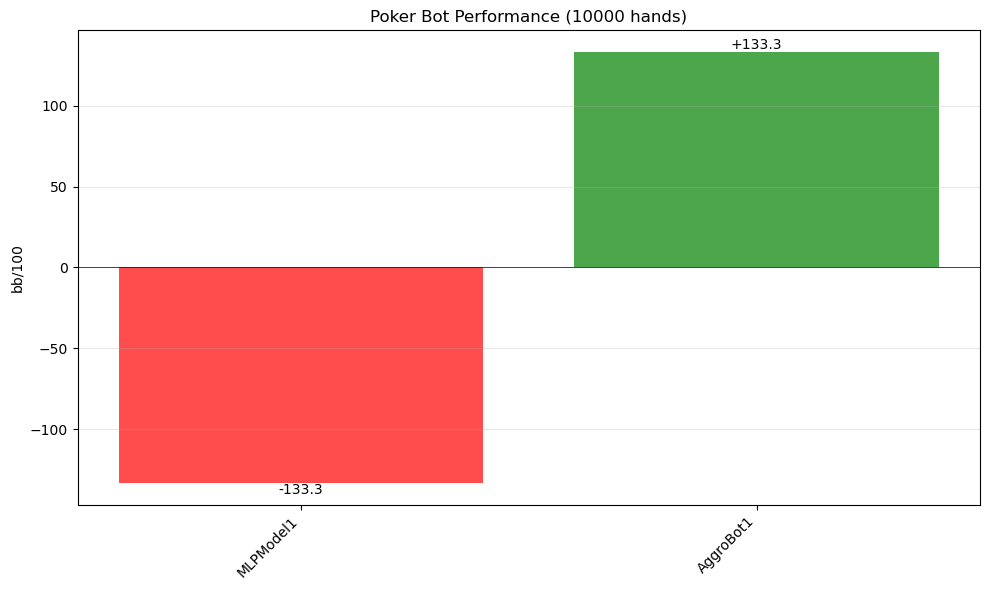


✓ Evaluation complete!


In [214]:
# Cell 18: Visualization
# Results bar chart
fig, ax = plt.subplots(figsize=(10, 6))

player_names = [p.name for p in players]
colors = ['red' if bb < 0 else 'green' for bb in bb_per_100]

bars = ax.bar(player_names, bb_per_100, color=colors, alpha=0.7)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylabel('bb/100')
ax.set_title('Poker Bot Performance (10000 hands)')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, bb_per_100):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:+.1f}',
            ha='center', va='bottom' if height > 0 else 'top')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n✓ Evaluation complete!")